# **Multi Class Classification**

## **Imports**

In [1]:
# Imports
import torch
from torch import nn

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## **Device Agnostic Setting**

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## **Constants**

In [3]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

## **Data Creation**

In [4]:
# Generate multi-class data
X_blob, y_blob = make_blobs(n_samples = 20_000, n_features = NUM_FEATURES, centers = NUM_CLASSES, cluster_std = 1.5, random_state = RANDOM_SEED)

### **Convert Data to Tensors**

In [5]:
# Convert data to tensor
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [6]:
# Print the data samples
print(X_blob[:5])
print(y_blob[:5])

tensor([[-4.1289, -6.1309],
        [-1.9372, 11.0626],
        [ 2.6282,  4.2651],
        [ 4.7976,  1.0242],
        [ 0.7938,  8.4801]])
tensor([2, 0, 1, 1, 0])


### **Plot Data**

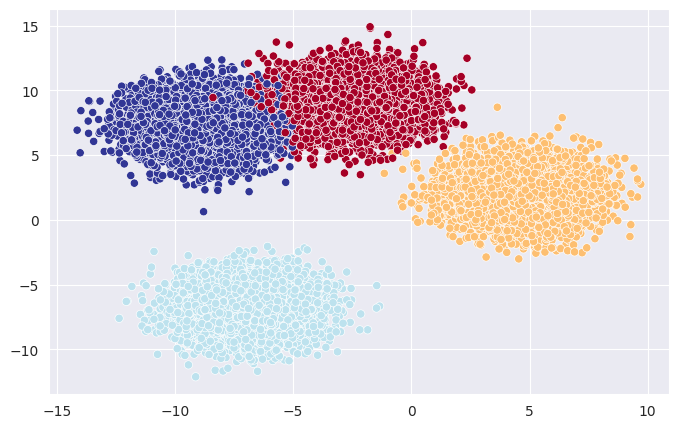

In [7]:
# Plot the data
plt.figure(figsize = (8, 5))
sns.scatterplot(x = X_blob[:, 0], y = X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)
plt.show()

## **Train Test Split**

In [8]:
# Split the data into train and test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size = 0.2, random_state = RANDOM_SEED)

## **Model Building**

In [9]:
# Create a class for the classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
                (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()

        # Use neural network nn.Sequential() for adding layers to model
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = output_features)
        )

    # forward() computation
    def forward(self, x):
        return self.linear_layer_stack(x)

### **Initialize Model**

In [10]:
# Initialize an instance of model
blob_model = BlobModel(input_features = NUM_FEATURES,
                       output_features = NUM_CLASSES,
                       hidden_units = 8).to(device)
blob_model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### **Loss, Optimizer and Performance Metrics**

In [11]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(blob_model.parameters(), lr = 1e-2)

In [12]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    # Get the count of correct predictions
    correct_count = torch.eq(y_true, y_pred).sum().item()

    # Calculate the accuracy
    acc = (correct_count / len(y_pred)) * 100

    # Return the accuracy
    return acc

### **Getting Predictions**

**`Before Training`**

In [13]:
# Get logits from the model for training data
y_train_pred_logits = blob_model(X_blob_train.to(device))
y_train_pred_logits[:5]

tensor([[-0.2013, -0.7295,  1.9367, -2.1792],
        [-0.3978, -0.5762,  0.0111, -0.7582],
        [ 0.7146, -0.2249,  2.1227, -1.1807],
        [ 0.4676, -0.4649,  2.8214, -2.0994],
        [ 0.6689, -0.2322,  1.9847, -1.1189]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [14]:
# Apply softmax activation to logits to get probability for each class
y_train_pred_probs = torch.softmax(y_train_pred_logits, dim = 1)
y_train_pred_probs[:5]

tensor([[0.0979, 0.0578, 0.8308, 0.0136],
        [0.2476, 0.2071, 0.3726, 0.1727],
        [0.1776, 0.0694, 0.7262, 0.0267],
        [0.0834, 0.0328, 0.8774, 0.0064],
        [0.1886, 0.0766, 0.7032, 0.0316]], device='cuda:0',
       grad_fn=<SliceBackward0>)

## **Training and Testing Loop**

### **Move Data to Device**

In [15]:
# Put data to device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

### **Training and Evaluation**

In [16]:
# Set pytorch random seed
torch.manual_seed(42)

# Set number of epochs
epochs = 1_000

# Setup empty lists to track model progress
train_loss_values = []
test_loss_values = []
epoch_count = []

# Loop for number of epochs
for epoch in range(epochs):
    # Set the model to training model
    blob_model.train()

    # Get the logits and probabilities
    y_train_pred_logits = blob_model(X_blob_train)
    y_train_pred_probs = torch.softmax(y_train_pred_logits, dim = 1)

    # Get the predicted label from probabilities
    y_train_pred = y_train_pred_probs.argmax(dim = 1)

    # Calculate loss and accuracy
    train_loss = loss_fn(y_train_pred_logits, y_blob_train)
    train_acc = accuracy_fn(y_blob_train, y_train_pred)

    # Oprimizer zero grad
    optimizer.zero_grad()

    # Backpropogate the loss
    train_loss.backward()

    # Optimzer step
    optimizer.step()

    # Set the model to testing mode
    blob_model.eval()

    # Use inference_mode() for faster processing
    with torch.inference_mode():
        # Get the logits and probabilities
        y_test_pred_logits = blob_model(X_blob_test)
        y_test_pred_probs = torch.softmax(y_test_pred_logits, dim = 1)

        # Get the predicted label from probabilities
        y_test_pred = y_test_pred_probs.argmax(dim = 1)

        # Calculate loss and accuracy
        test_loss = loss_fn(y_test_pred_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, y_test_pred)

    # For every epochs track the progress
    if epoch % (epochs // 10) == 0:
        # Update the lists
        epoch_count.append(epoch)
        train_loss_values.append(train_loss.detach().to("cpu").numpy())
        test_loss_values.append(test_loss.detach().to("cpu").numpy())

        # Print the progress
        print(f"Epoch: {epoch}\t| Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Epoch: 0	| Train Loss: 3.8033 | Train Accuracy: 0.0063 | Test Loss: 2.9794 | Test Accuracy: 0.0750
Epoch: 100	| Train Loss: 0.1465 | Train Accuracy: 98.6437 | Test Loss: 0.1446 | Test Accuracy: 98.5750
Epoch: 200	| Train Loss: 0.0818 | Train Accuracy: 98.8500 | Test Loss: 0.0806 | Test Accuracy: 98.8750
Epoch: 300	| Train Loss: 0.0607 | Train Accuracy: 98.8688 | Test Loss: 0.0597 | Test Accuracy: 98.8500
Epoch: 400	| Train Loss: 0.0507 | Train Accuracy: 98.8875 | Test Loss: 0.0498 | Test Accuracy: 98.8500
Epoch: 500	| Train Loss: 0.0450 | Train Accuracy: 98.9062 | Test Loss: 0.0442 | Test Accuracy: 98.8500
Epoch: 600	| Train Loss: 0.0414 | Train Accuracy: 98.9125 | Test Loss: 0.0406 | Test Accuracy: 98.8250
Epoch: 700	| Train Loss: 0.0389 | Train Accuracy: 98.9188 | Test Loss: 0.0381 | Test Accuracy: 98.8250
Epoch: 800	| Train Loss: 0.0371 | Train Accuracy: 98.9250 | Test Loss: 0.0363 | Test Accuracy: 98.8250
Epoch: 900	| Train Loss: 0.0358 | Train Accuracy: 98.9250 | Test Loss: 0.0350

## **Predictions**

### **Get Logits**

In [17]:
# Set model to eval model
blob_model.eval()

# Put model to evaluation model
with torch.inference_mode():
    # Get the logits
    y_test_pred_logits = blob_model(X_blob_test)

# View the logits
y_test_pred_logits[:5]

tensor([[ -8.0424, -10.1320,  16.9711,   8.2296],
        [ -5.9484, -14.4913,  17.4478,  12.0732],
        [  1.0432,  10.7652,  -8.8139,  -8.8705],
        [  3.8079, -11.6219,   3.4515,  10.3146],
        [  4.9243, -17.3509,   6.0878,  15.2525]], device='cuda:0')

### **Get Probabilities**

In [18]:
# Get the probabilities
y_test_pred_probs = torch.softmax(y_test_pred_logits, dim = 1)

# Turn probabilities into prediction labels
y_test_pred = y_test_pred_probs.argmax(dim = 1)

### **Classification Report**

In [19]:
# Print classification report
print(classification_report(y_blob_test.to("cpu"), y_test_pred.to("cpu")))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       976
           1       1.00      1.00      1.00      1012
           2       1.00      1.00      1.00      1008
           3       0.98      0.98      0.98      1004

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



### **Download File and Import Helper Functions**

In [20]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

### **Decision Boundary**

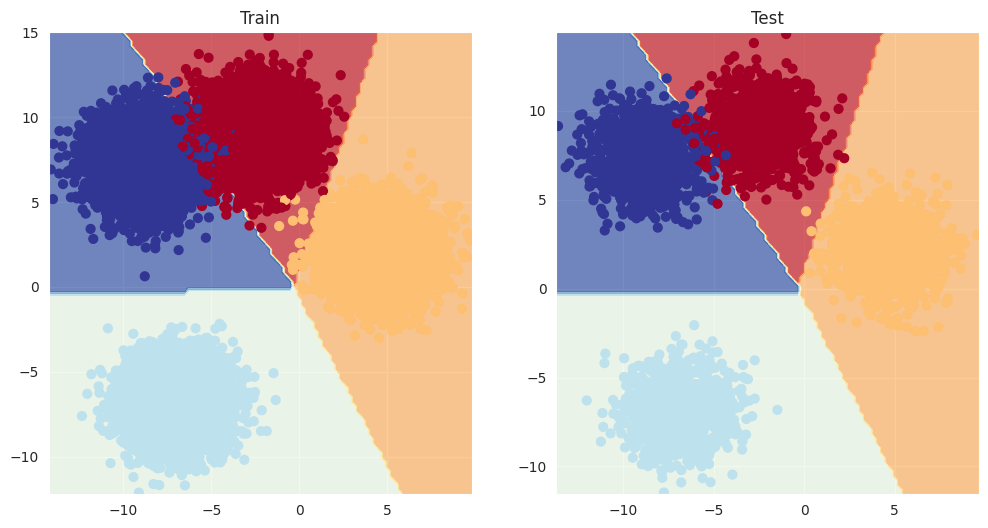

In [21]:
# Chagne figure size
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(blob_model, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(blob_model, X_blob_test, y_blob_test)

plt.show()

### **PyTorch Metrics**

In [22]:
# Import accuracy from torchmetrics
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics --quiet
    from torchmetrics import Accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 25.0 MB/s eta 0:00:00


In [23]:
# Setup metric and move to target device
torchmetrics_accuracy = Accuracy(task = "multiclass", num_classes = 4).to(device)

In [24]:
# Calculate accuracy
torchmetrics_accuracy(y_test_pred, y_blob_test)

tensor(0.9883, device='cuda:0')

## **Save Model**

In [25]:
# Mount google drive
from google.colab import drive
drive.mount("./Drive", force_remount = True)

Mounted at ./Drive


In [26]:
# Create models directory
MODEL_PATH = Path("./Drive/MyDrive/PyTorch Course/models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# Create model save path
MODEL_NAME = "02_pytorch_multi_class_classification.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving Model to: {MODEL_SAVE_PATH}")
torch.save(obj = blob_model.state_dict(), f = MODEL_SAVE_PATH)

Saving Model to: Drive/MyDrive/PyTorch Course/models/02_pytorch_multi_class_classification.pth


In [27]:
# Check the saved file path
!ls -l "./Drive/MyDrive/PyTorch Course/models/02_pytorch_multi_class_classification.pth"

-rw------- 1 root root 3143 Jul 19 04:52 './Drive/MyDrive/PyTorch Course/models/02_pytorch_multi_class_classification.pth'


## **Load Model**

### **Initialize Model**

In [28]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_blob_model = BlobModel(input_features = NUM_FEATURES,
                              output_features = NUM_CLASSES,
                              hidden_units = 8).to(device)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_blob_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<All keys matched successfully>

### **Generate Outputs**

In [29]:
# Put the loaded model into evaluation mode
loaded_blob_model.eval()

# Put model to evaluation model
with torch.inference_mode():
    # Get the logits
    loaded_y_test_pred_logits = loaded_blob_model(X_blob_test)

# Get the probabilities
loaded_y_test_pred_probs = torch.softmax(loaded_y_test_pred_logits, dim = 1)

# Turn probabilities into prediction labels
loaded_y_test_pred = loaded_y_test_pred_probs.argmax(dim = 1)

### **Print Classification Report**

In [30]:
# Print the classification report
print(classification_report(y_blob_test.to("cpu"), loaded_y_test_pred.to("cpu")))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       976
           1       1.00      1.00      1.00      1012
           2       1.00      1.00      1.00      1008
           3       0.98      0.98      0.98      1004

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

